## Bermuda Swaptions

Pre-requisites: Notebook 1.1, 1.2, 1.4

In this notebook we will create and price **vanilla swaptions** and **bermuda swaptions**. In that process we will

- use a contract with multiple **tracks**
- option to switch from one track to another
- use `HWFDModel` (a Finite Difference Hull-White Model)

API documentation:

- [Utilities to create swaps and swaptions](https://qablet.github.io/qablet-contracts/examples/rate/)
- [Hull White FD model](https://qablet-academy.github.io/intro/models/fd/#hull-white-model)

Let us start with the imports.

In [1]:
from datetime import datetime, timezone

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qablet.base.flags import Stats
from qablet.hullwhite.fd import HWFDModel
from qablet_contracts.ir.swaption import BermudaSwaption, Swaption

## Create Timetable
In a Vanilla swaption the holder gets the opportunity to enter into the swap at the beginning of the first period. However, in a Bermuda swaption the holder gets multiple opprtunities to enter a swap. In the variant shown here, known as a Co-terminal Bermuda swaption, the holder can exercise his option at the beginning of each swap period. Once exercised, the holder pays and receives all remaining payments of the swap.
 
The timetable below has two tracks, `.opt` and `.swp`. 
- All the payments happen on the `.swp` track. 
- The holder starts in the track `.opt`, and has an option in the beginning of each period, to switch to the `.swp` track. This is represented by having `.swp` as the target unit in each option event, instead of an asset or cash.

In [2]:
# swap starts six months from now, mature in two years, pays six monthly.
period_dts = pd.bdate_range(
    datetime(2024, 6, 30), datetime(2025, 12, 31), freq="2QE", inclusive="both"
)
fixed_rate = 0.03
bswo_timetable = BermudaSwaption(
    "USD", period_dts, strike_rate=fixed_rate
).timetable()
print(bswo_timetable["events"].to_pandas())

                       time op  quantity  unit track
0 2024-06-30 00:00:00+00:00  >     1.000  .swp  .opt
1 2024-06-30 00:00:00+00:00  +     1.000   USD  .swp
2 2024-12-31 00:00:00+00:00  +    -1.015   USD  .swp
3 2024-12-31 00:00:00+00:00  >     1.000  .swp  .opt
4 2024-12-31 00:00:00+00:00  +     1.000   USD  .swp
5 2025-06-30 00:00:00+00:00  +    -1.015   USD  .swp
6 2025-06-30 00:00:00+00:00  >     1.000  .swp  .opt
7 2025-06-30 00:00:00+00:00  +     1.000   USD  .swp
8 2025-12-31 00:00:00+00:00  +    -1.015   USD  .swp


In [3]:
# Compare with a vanilla swaption
swo_timetable = Swaption("USD", period_dts, strike_rate=fixed_rate).timetable()
print(swo_timetable["events"].to_pandas())

                       time op  quantity  unit track
0 2024-06-30 00:00:00+00:00  >     1.000  .swp  .opt
1 2024-06-30 00:00:00+00:00  +     1.000   USD  .swp
2 2024-12-31 00:00:00+00:00  +    -1.015   USD  .swp
3 2024-12-31 00:00:00+00:00  +     1.000   USD  .swp
4 2025-06-30 00:00:00+00:00  +    -1.015   USD  .swp
5 2025-06-30 00:00:00+00:00  +     1.000   USD  .swp
6 2025-12-31 00:00:00+00:00  +    -1.015   USD  .swp


We will price it with a Hull-White Finite-Difference model, which requires a mean reversion and volatility parameter in the dataset. For details of the model parameters see [Hull White FD model](https://qablet-academy.github.io/intro/models/fd/#hull-white-model).

In [4]:
max_year = 5
base_rate = 0.0297
pricing_dt = datetime(2023, 12, 31, tzinfo=timezone.utc)
hwfd_dataset = {
    "BASE": "USD",
    "PRICING_TS": pricing_dt,
    "ASSETS": {"USD": ("ZERO_RATES", np.array([[max_year, base_rate]]))},
    "FD": {
        "TIMESTEP": 1 / 250,
        "MAX_X": 0.20,
        "N_X": 75,
    },
    "HW": {
        "MEANREV": 0.1,
        "VOL": 0.03,
    },
}

hw_model = HWFDModel()

Let's compare the prices of vanilla swaption with bermuda swaption for different vols. We expect the bermuda swaption to have consistently higher price.

In [5]:
data = []
for vol in np.linspace(0.0, 0.1, 6):
    hwfd_dataset["HW"]["VOL"] = vol  # update the vol in the dataset
    v_price, _ = hw_model.price(swo_timetable, hwfd_dataset)
    b_price, _ = hw_model.price(bswo_timetable, hwfd_dataset)
    data.append([vol, v_price, b_price])

pd.options.display.float_format = "{:,.4f}".format
df = pd.DataFrame(data, columns=["vol", "vanilla", "bermuda"])
print(df)

     vol  vanilla  bermuda
0 0.0000   0.0000   0.0001
1 0.0200   0.0074   0.0094
2 0.0400   0.0149   0.0188
3 0.0600   0.0223   0.0283
4 0.0800   0.0298   0.0378
5 0.1000   0.0373   0.0474


# Pricing Stats (Choices)

The qablet package provides some ways to analyse the behavior of the pricing model. In previous notebooks we have used the `PV_VEC` flag to produce the distribution of prices. Here we will use the `CHOICES` flag to examine what exercise decisions are being taken during the model execution. We will use an 1+10 swaption this time.

In [6]:
# Start after 1 year, mature at 11 years, pay annually (ten periods).
period_dts = pd.bdate_range(
    datetime(2024, 12, 31), datetime(2034, 12, 31), freq="YE", inclusive="both"
)
fixed_rate = 0.03
bswo_timetable = BermudaSwaption(
    "USD", period_dts, strike_rate=fixed_rate
).timetable()
# print(bswo_timetable["events"].to_pandas())

In [7]:
hwfd_dataset = {
    "BASE": "USD",
    "PRICING_TS": pricing_dt,
    "ASSETS": {"USD": ("ZERO_RATES", np.array([[12, base_rate]]))},
    "FD": {
        "TIMESTEP": 1 / 250,
        "MAX_X": 0.20,
        "N_X": 75,
        "FLAGS": Stats.CHOICES,  # Set this flag to get the stats on exercise decisions
    },
    "HW": {
        "MEANREV": 0.1,
        "VOL": 0.03,
    },
}
price, stats = hw_model.price(bswo_timetable, hwfd_dataset)
print(price)

0.13021120208866344


The returned stats now contains an element `CHOICES` which is a dictionary. The keys are the timetable indexes which correspond to an option event. The values are vectors of length $2 * N_X + 1$, containing 0 or 1. If the event looks like below, 0 indicates that the model `continued` to next event, i.e. did not exercise into the swap. 1 indicates that it `accepted` the `unit`, i.e. exercise into the swap.

```python
  track   time op  quantity  unit
0  .opt 0.5000  >    1.0000  .swp
```

In [8]:
choices = stats["CHOICES"]
print(choices.keys())  # we will see indices of the 10 exercise events
print(
    choices[3]
)  # we will see exercise decisions for each value along the rate axis, for this particular exercise event

dict_keys([12, 9, 27, 15, 3, 18, 0, 24, 21, 6])
{0: array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=uint64)}


We will now plot the decisions, against the rates, with time on x-axis, and the rate offset along the y axis.

In [9]:
event_idxs = list(choices.keys())
event_idxs.sort()

# Get the decisions
decisions = np.array([choices[i][0] for i in event_idxs]).transpose()
exer_dts = [
    bswo_timetable["events"]["time"][idx].as_py() for idx in event_idxs
]
rates_x = np.linspace(0.2, -0.2, decisions.shape[0])

Text(0, 0.5, 'Rate offset')

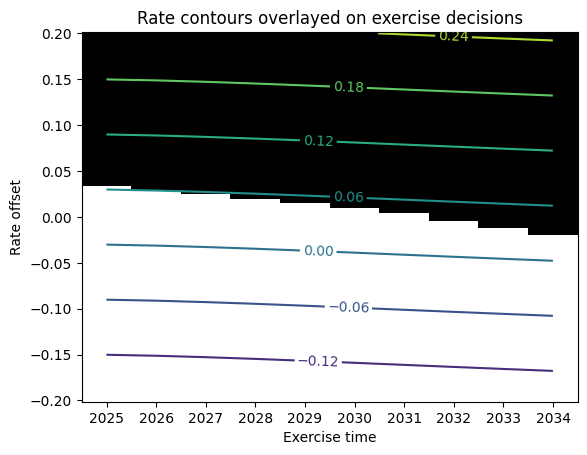

In [10]:
# In the Hull White model the actual rate on the grid is the rate offset plus a deterministic component (rate_base) as calculated below
mkt_rate = 0.02977
mr = hwfd_dataset["HW"]["MEANREV"]
vol = hwfd_dataset["HW"]["VOL"]
exer_yrs = [(dt - pricing_dt).days / 365.25 for dt in exer_dts]
decay = 1 - np.exp(-mr * np.array(exer_yrs))
rate_base = mkt_rate + vol * vol / (2 * mr * mr) * decay * decay
rates = np.array([rate_base + x for x in rates_x])

# Plot the rate contours
fig, ax = plt.subplots()
CS = ax.contour(exer_dts, rates_x, rates)
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title("Rate contours overlayed on exercise decisions")

# Plot the decisions as a colormesh
M = ax.pcolormesh(exer_dts, rates_x, decisions, cmap="Greys")
ax.set_xlabel("Exercise time")
ax.set_ylabel("Rate offset")

## Suggested Exercises

- Create and price a prepayable amortizing loan, or a cancellable swap.
- Show how the bermuda swaption is a hedge for the above products by shifting rates on both.
- Study the impact of steepening or flattening yield curve on the exercise decisions.

Next: [Define your own Monte-Carlo Model](2_1_custom_mc.ipynb)